In [10]:
import folium
import json
import pandas as pd
import numpy as np
import os
import seaborn as sns
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
import statsmodels.api as sm

# import geopandas as gpd
# from shapely.geometry import Polygon, LineString, Point
# import fiona

In [2]:
from matplotlib import font_manager, rc
font_path = "data/THEdog.ttf"   #폰트파일의 위치
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

import matplotlib.pyplot as plt


%matplotlib inline

In [3]:
data_final = pd.read_csv("output/그리드 전처리 완료/final_data2.csv")
data_final

,gid,acci_cnt,2030val,과속방지턱,무인카메라,신호등,버스아침승차,버스아침하차,버스저녁승차,버스저녁하차,...,스포츠,음식점,학교,교육,출근시간자전거,퇴근시간자전거,지하철아침승차,지하철아침하차,지하철저녁승차,지하철저녁하차
0,다사542434,1.0,0.0,0.0,0.0,0.0,0.00,0.00,0.000000,0.000000,...,0.0,0.0,0.0,0.0,46,201,0.0,0.0,0.0,0.0
1,다사547430,1.0,0.0,0.0,0.0,0.0,0.00,0.00,0.000000,0.000000,...,0.0,0.0,0.0,0.0,53,137,0.0,0.0,0.0,0.0
2,다사549419,1.0,67.0,0.0,0.0,0.0,0.00,0.00,0.000000,0.000000,...,0.0,0.0,0.0,0.0,2,10,0.0,0.0,0.0,0.0
3,다사551417,1.0,26.0,0.0,0.0,0.0,2486.75,3392.25,1914.833333,3168.333333,...,0.0,1.0,0.0,0.0,3,9,0.0,0.0,0.0,0.0
4,다사564435,1.0,0.0,0.0,0.0,0.0,0.00,0.00,0.000000,0.000000,...,0.0,3.0,0.0,0.0,16,54,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8983,다사559438,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.000000,0.000000,...,0.0,0.0,0.0,0.0,23,105,0.0,0.0,0.0,0.0
8984,다사618387,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0
8985,다사559464,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.000000,0.000000,...,0.0,0.0,0.0,0.0,135,886,0.0,0.0,0.0,0.0
8986,다사585417,0.0,0.0,0.0,0.0,7.0,0.00,0.00,0.000000,0.000000,...,0.0,0.0,0.0,1.0,219,303,0.0,0.0,0.0,0.0


### 정규화 진행

In [5]:
data_final2 = data_final.set_index('gid')
data_final2

,acci_cnt,2030val,과속방지턱,무인카메라,신호등,버스아침승차,버스아침하차,버스저녁승차,버스저녁하차,관광여가오락,...,스포츠,음식점,학교,교육,출근시간자전거,퇴근시간자전거,지하철아침승차,지하철아침하차,지하철저녁승차,지하철저녁하차
gid,,,,,,,,,,,,,,,,,,,,,
다사542434,1.0,0.0,0.0,0.0,0.0,0.00,0.00,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,46,201,0.0,0.0,0.0,0.0
다사547430,1.0,0.0,0.0,0.0,0.0,0.00,0.00,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,53,137,0.0,0.0,0.0,0.0
다사549419,1.0,67.0,0.0,0.0,0.0,0.00,0.00,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,2,10,0.0,0.0,0.0,0.0
다사551417,1.0,26.0,0.0,0.0,0.0,2486.75,3392.25,1914.833333,3168.333333,0.0,...,0.0,1.0,0.0,0.0,3,9,0.0,0.0,0.0,0.0
다사564435,1.0,0.0,0.0,0.0,0.0,0.00,0.00,0.000000,0.000000,0.0,...,0.0,3.0,0.0,0.0,16,54,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
다사559438,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,23,105,0.0,0.0,0.0,0.0
다사618387,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0
다사559464,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,135,886,0.0,0.0,0.0,0.0


In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_final2[:] = scaler.fit_transform(data_final2[:])

In [8]:
data_final2

,acci_cnt,2030val,과속방지턱,무인카메라,신호등,버스아침승차,버스아침하차,버스저녁승차,버스저녁하차,관광여가오락,...,스포츠,음식점,학교,교육,출근시간자전거,퇴근시간자전거,지하철아침승차,지하철아침하차,지하철저녁승차,지하철저녁하차
gid,,,,,,,,,,,,,,,,,,,,,
다사542434,0.5,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.118557,0.089175,0.0,0.0,0.0,0.0
다사547430,0.5,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.136598,0.060781,0.0,0.0,0.0,0.0
다사549419,0.5,0.067269,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.005155,0.004437,0.0,0.0,0.0,0.0
다사551417,0.5,0.026104,0.0,0.0,0.000000,0.080009,0.268385,0.186548,0.430229,0.0,...,0.0,0.003984,0.0,0.000000,0.007732,0.003993,0.0,0.0,0.0,0.0
다사564435,0.5,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.011952,0.0,0.000000,0.041237,0.023957,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
다사559438,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.059278,0.046584,0.0,0.0,0.0,0.0
다사618387,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
다사559464,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.347938,0.393079,0.0,0.0,0.0,0.0


# y = 사고

In [21]:
# 전진단계별 선택법

variables = data_final2[[ '2030val', '과속방지턱', '무인카메라', '신호등', '버스아침승차',
       '버스아침하차', '버스저녁승차', '버스저녁하차', '관광여가오락', '부동산', '생활서비스', '소매점', '숙박',
       '스포츠', '음식점', '학교', '교육', '출근시간자전거', '퇴근시간자전거', '지하철아침승차', '지하철아침하차',
       '지하철저녁승차', '지하철저녁하차']]
y = data_final2[['acci_cnt']]


selected_variables = [] ## 선택된 변수들
sl_enter = 0.05
sl_remove = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
    ## 선형 모형을 적합한다.
    for col in remainder: 
        X = data_final2[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        ## 선택된 변수들에대해서
        ## 어떤 변수를 제거할지 고른다.
        while len(selected_variables) > 0:
            selected_X = data_final2[selected_variables]
            selected_X = sm.add_constant(selected_X)
            selected_pval = sm.OLS(y,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
            max_pval = selected_pval.max()
            if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                remove_variable = selected_pval.idxmax()
                selected_variables.remove(remove_variable)
            else:
                break
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(data_final2[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

<ipython-input-21-70bec746d5df>:20: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pval = pd.Series(index=remainder) ## 변수의 p-value
<ipython-input-21-70bec746d5df>:20: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pval = pd.Series(index=remainder) ## 변수의 p-value
<ipython-input-21-70bec746d5df>:20: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pval = pd.Series(index=remainder) ## 변수의 p-value
<ipython-input-21-70bec746d5df>:20: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pval = pd.Series(index=remainder) ## 

In [22]:
selected_variables

['신호등', '버스저녁하차', '음식점', '소매점', '무인카메라', '생활서비스', '2030val']

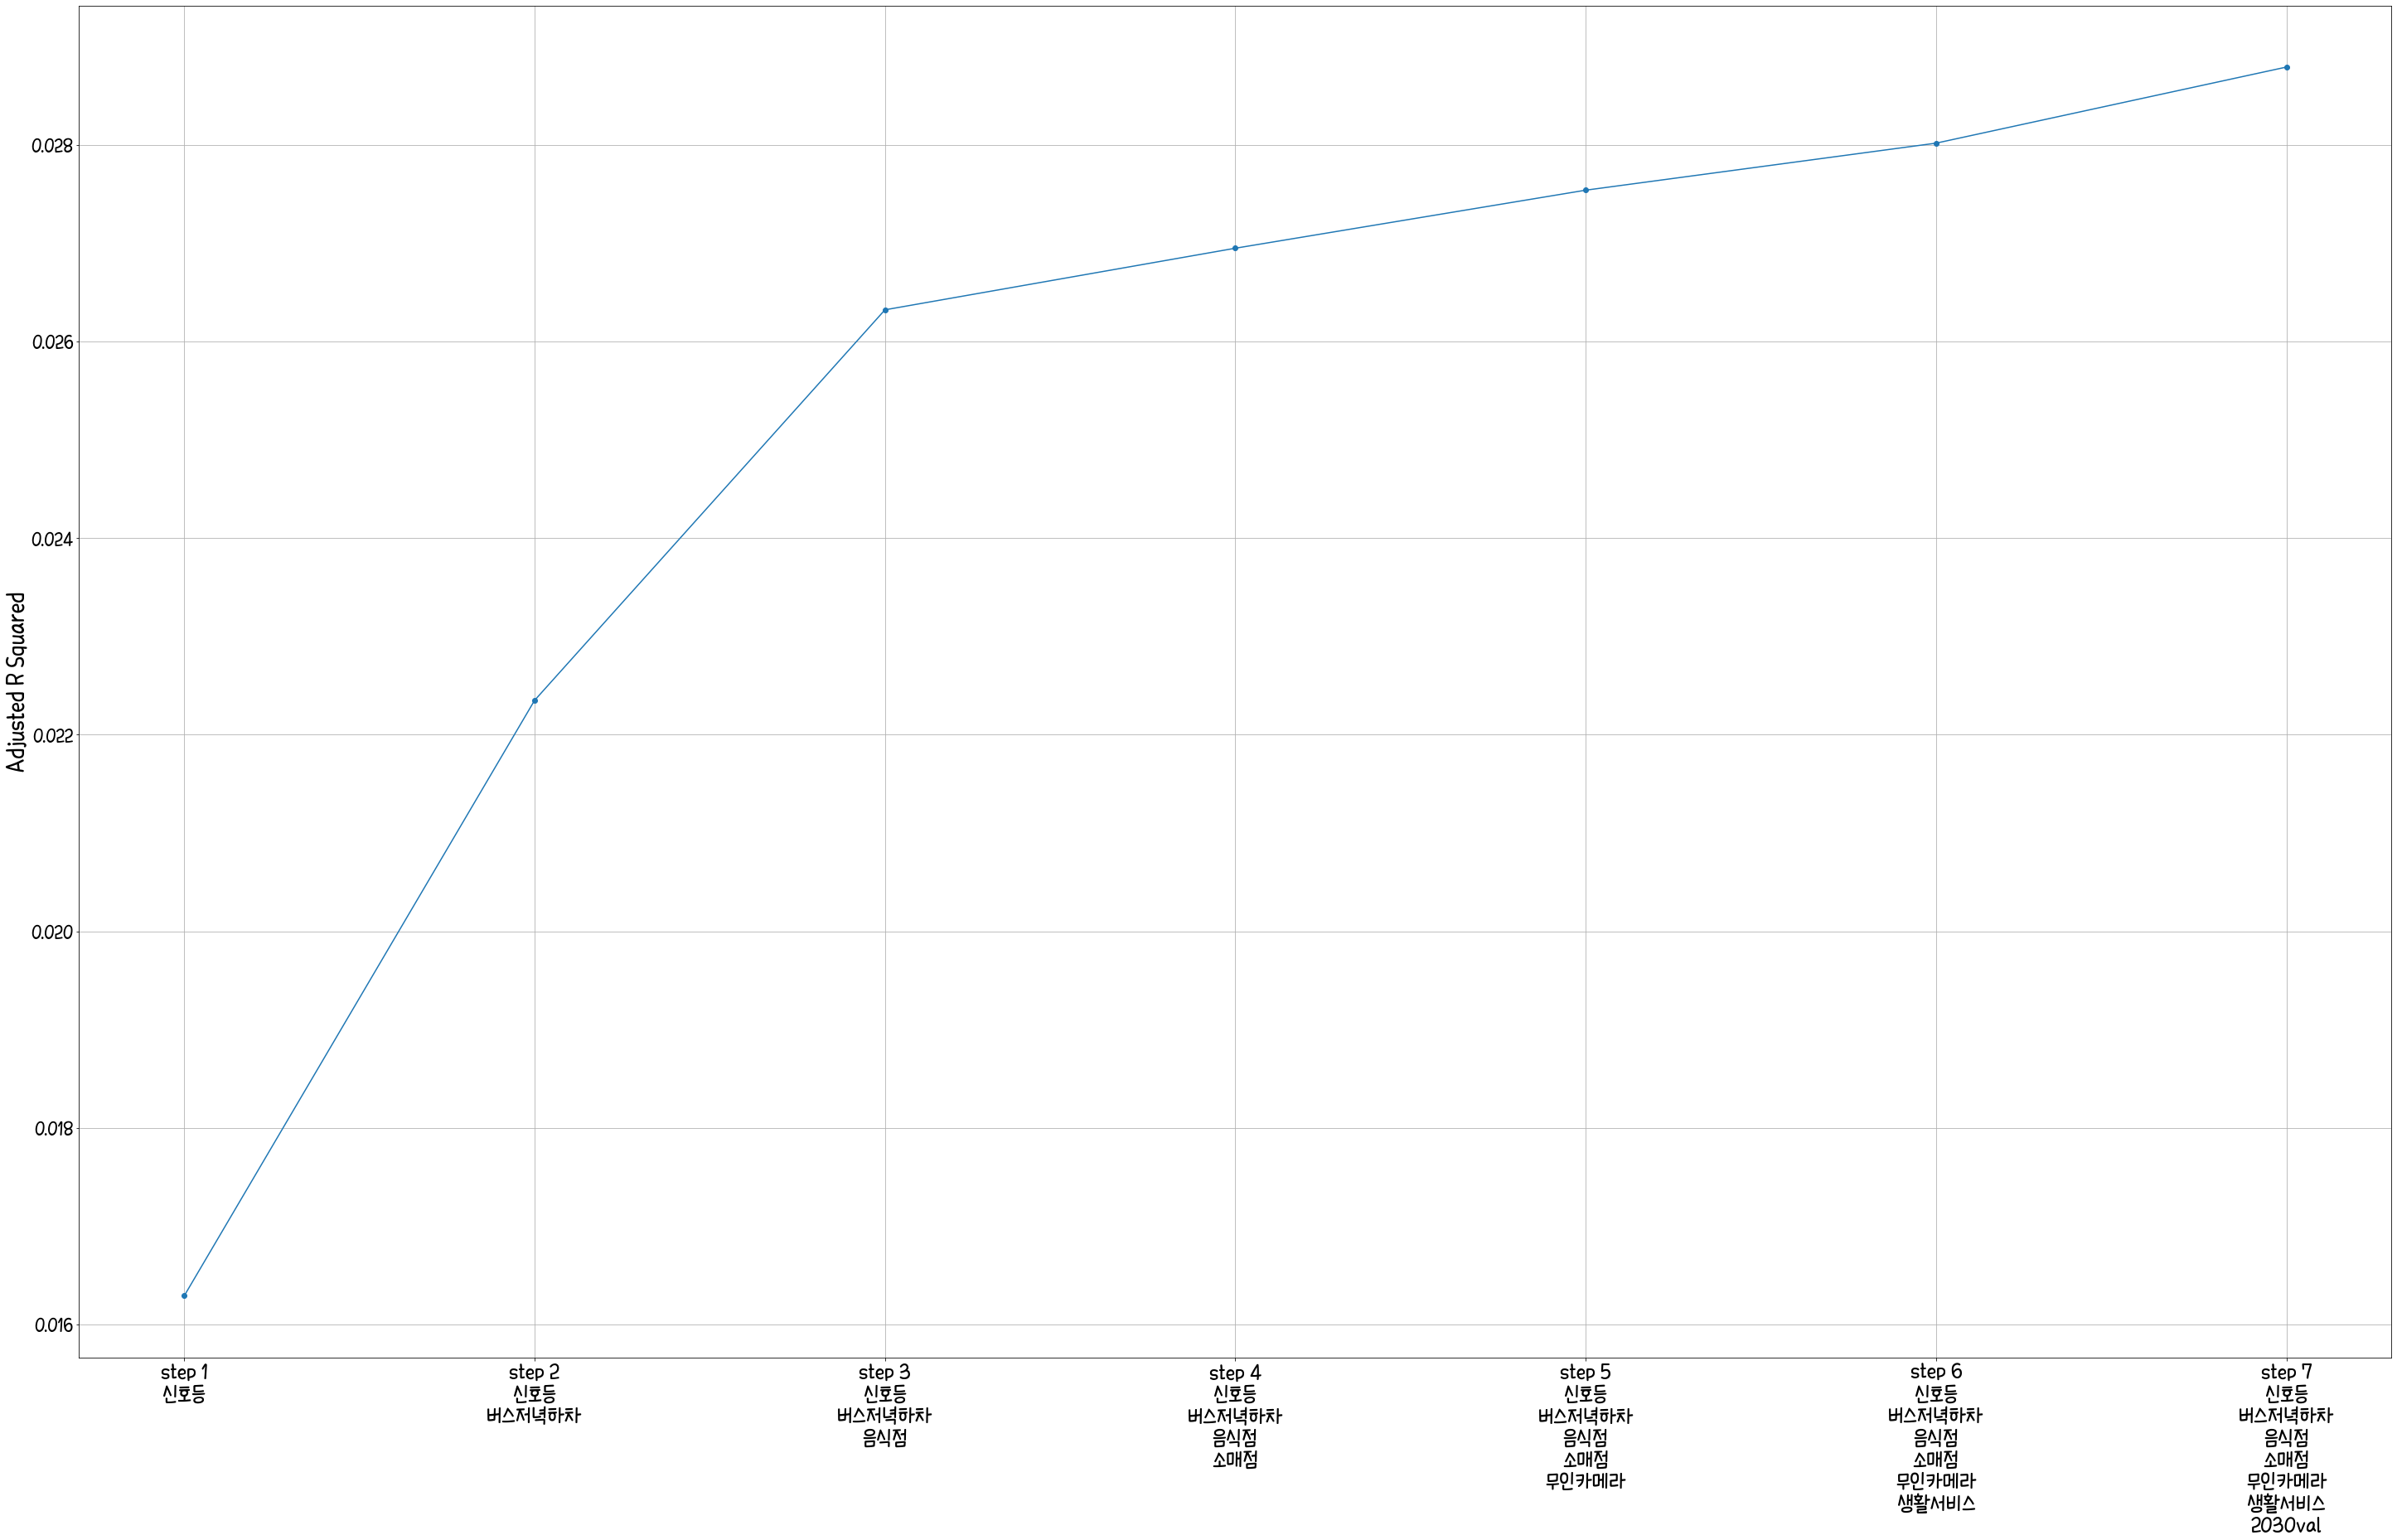

In [23]:
plt.rcParams['font.size'] =23

# upper matrix
fig = plt.figure(figsize=(50,30))
fig.set_facecolor('white')
 
font_size = 30
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=27)
plt.plot(steps,adjusted_r_squared, marker='o')
    
plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.savefig('output/그리드 전처리 완료/정규화종속변수사고전진단계.png')

# y = 2030val

In [24]:
# 전진단계별 선택법

variables = data_final2[[ 'acci_cnt', '과속방지턱', '무인카메라', '신호등', '버스아침승차',
       '버스아침하차', '버스저녁승차', '버스저녁하차', '관광여가오락', '부동산', '생활서비스', '소매점', '숙박',
       '스포츠', '음식점', '학교', '교육', '출근시간자전거', '퇴근시간자전거', '지하철아침승차', '지하철아침하차',
       '지하철저녁승차', '지하철저녁하차']]
y = data_final2[['2030val']]


selected_variables = [] ## 선택된 변수들
sl_enter = 0.05
sl_remove = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
    ## 선형 모형을 적합한다.
    for col in remainder: 
        X = data_final2[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        ## 선택된 변수들에대해서
        ## 어떤 변수를 제거할지 고른다.
        while len(selected_variables) > 0:
            selected_X = data_final2[selected_variables]
            selected_X = sm.add_constant(selected_X)
            selected_pval = sm.OLS(y,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
            max_pval = selected_pval.max()
            if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                remove_variable = selected_pval.idxmax()
                selected_variables.remove(remove_variable)
            else:
                break
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(data_final2[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

<ipython-input-24-e5260265c7fa>:20: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pval = pd.Series(index=remainder) ## 변수의 p-value
<ipython-input-24-e5260265c7fa>:20: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pval = pd.Series(index=remainder) ## 변수의 p-value
<ipython-input-24-e5260265c7fa>:20: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pval = pd.Series(index=remainder) ## 변수의 p-value
<ipython-input-24-e5260265c7fa>:20: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pval = pd.Series(index=remainder) ## 

In [25]:
selected_variables

['생활서비스',
 '부동산',
 '버스아침하차',
 '숙박',
 '출근시간자전거',
 '신호등',
 '소매점',
 'acci_cnt',
 '학교',
 '버스저녁하차',
 '버스저녁승차',
 '음식점',
 '관광여가오락']

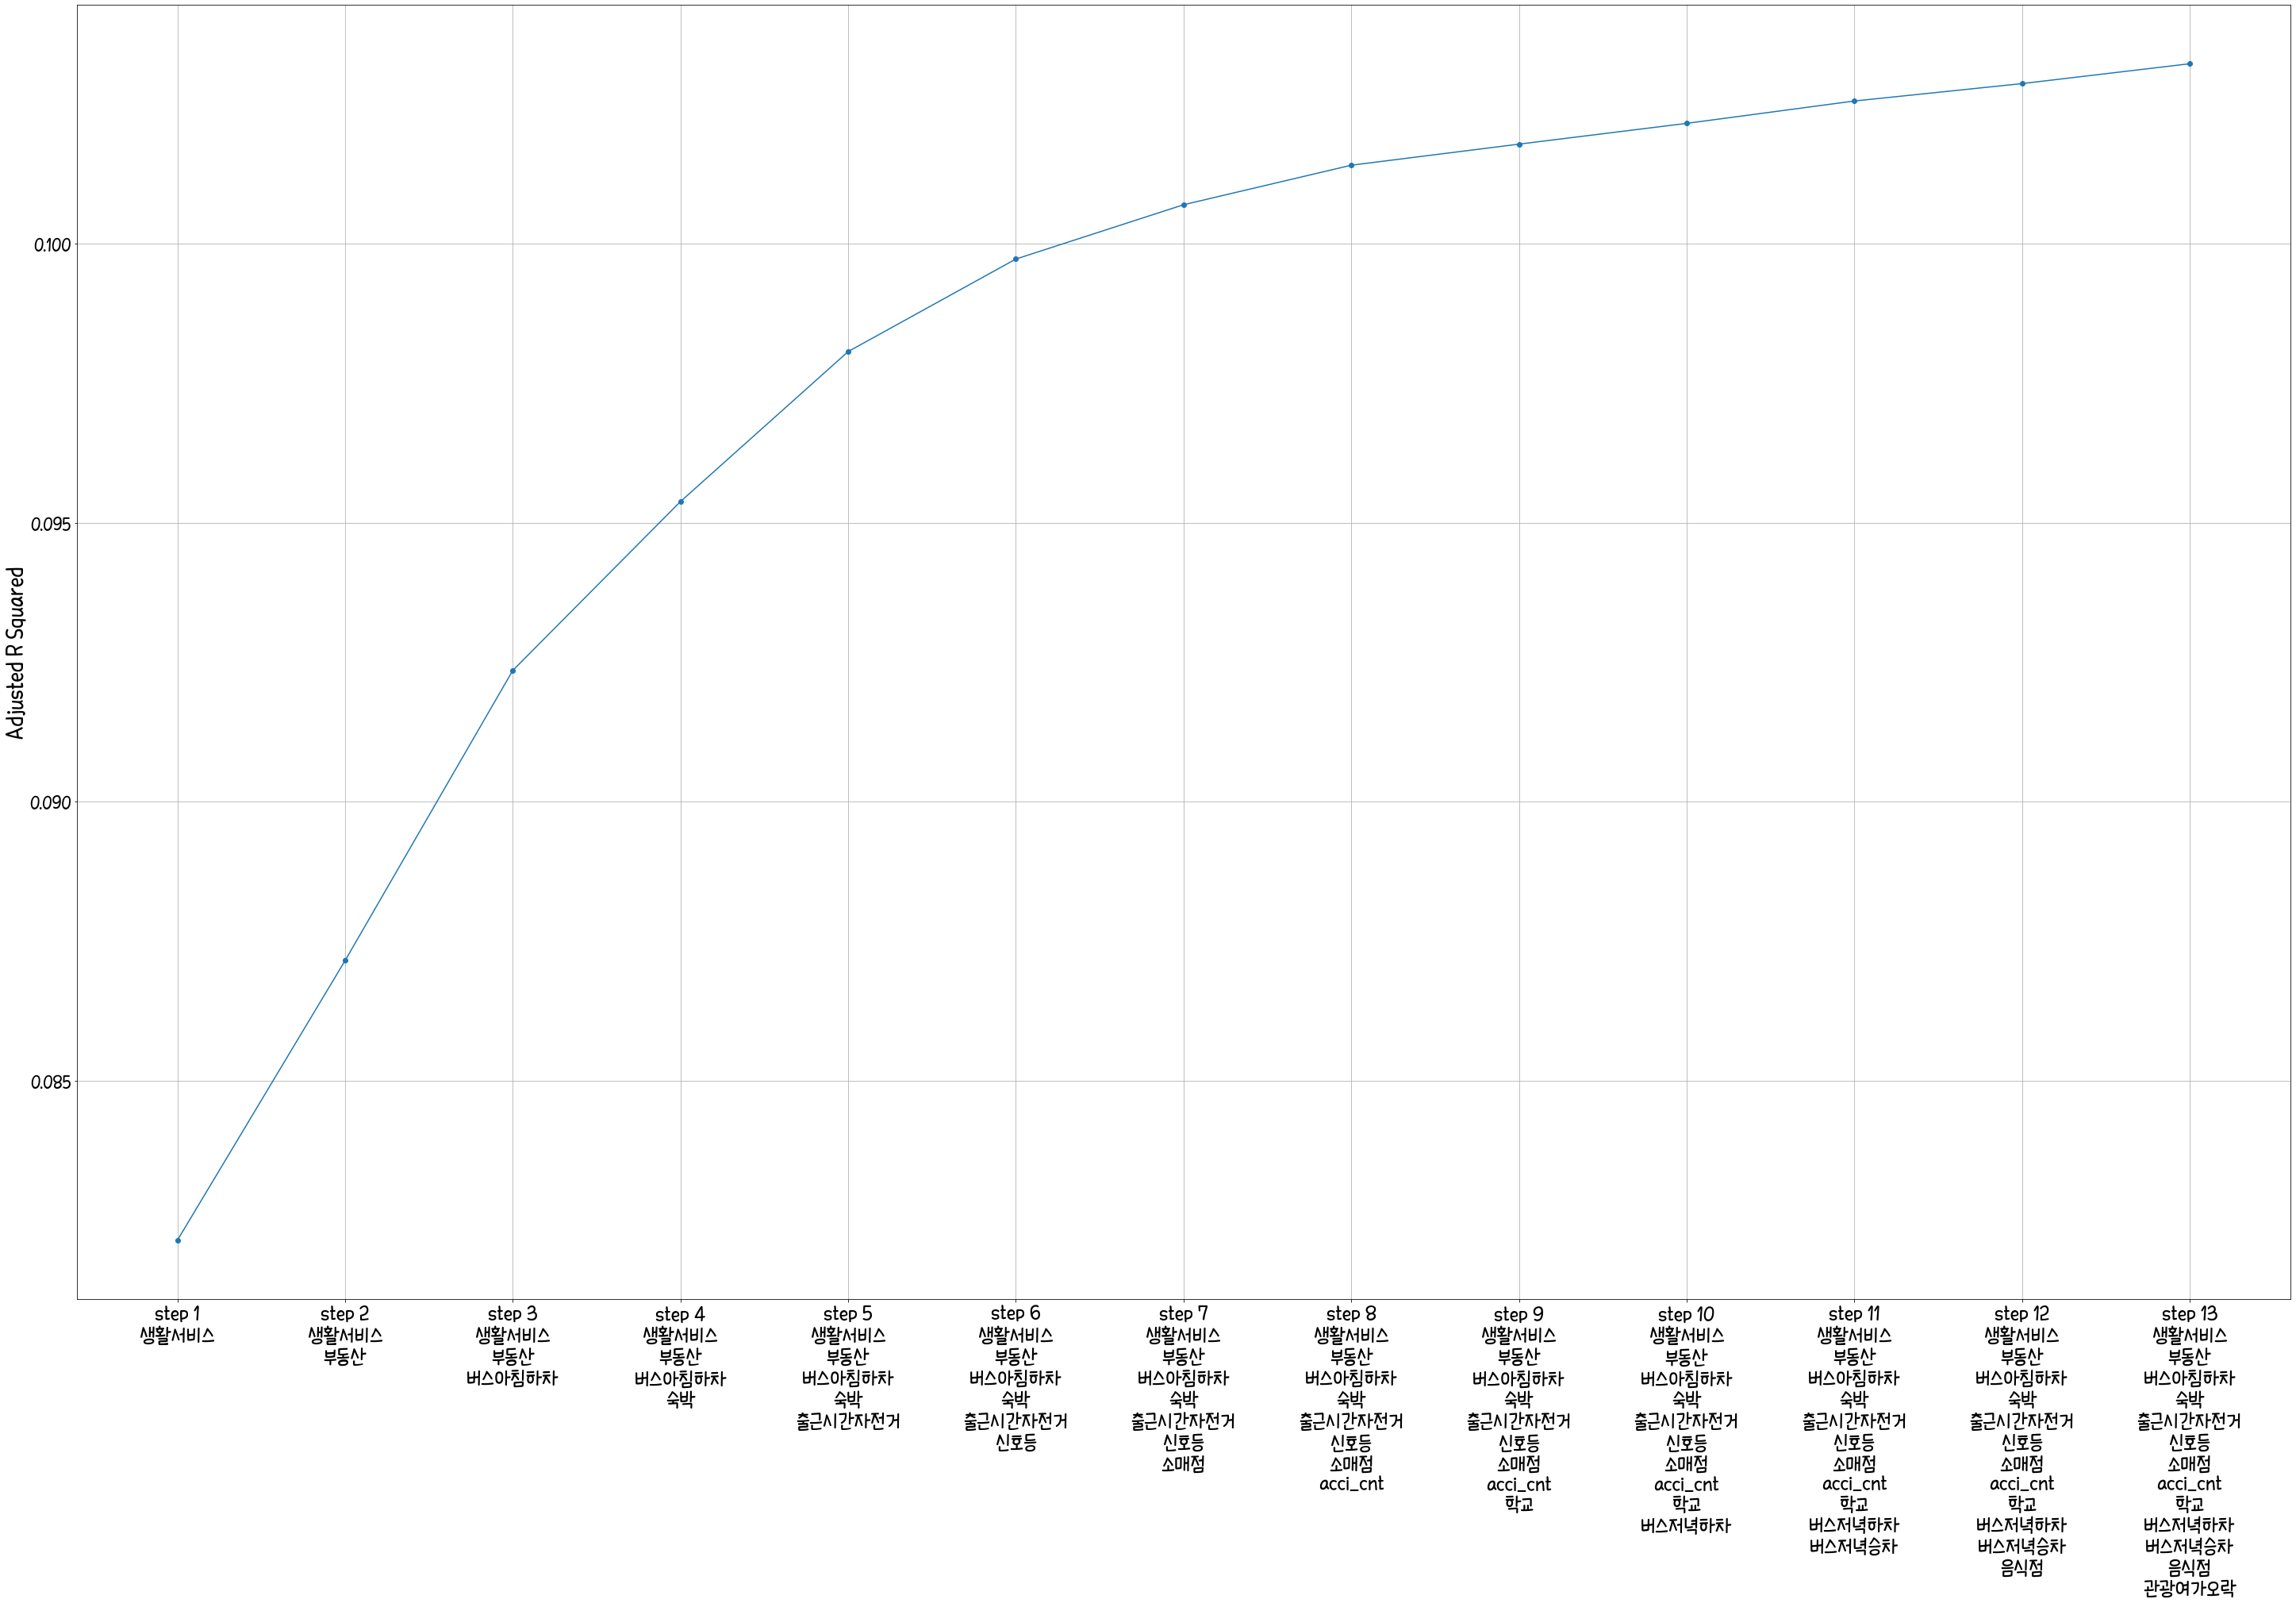

In [26]:
plt.rcParams['font.size'] =23

# upper matrix
fig = plt.figure(figsize=(50,30))
fig.set_facecolor('white')
 
font_size = 30
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=27)
plt.plot(steps,adjusted_r_squared, marker='o')
    
plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.savefig('output/그리드 전처리 완료/정규화종속변수인구전진단계.png')

In [ ]:
"""
#x_train, x_test, y_train, y_test = train_test_split(x_adjust3, y, train_size=0.8, test_size=0.2)
#x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2)
x_train, x_test, y_train, y_test = train_test_split(x_adjust, y, train_size=0.8, test_size=0.2)
mlr = LinearRegression()
mlr.fit(x_train, y_train) 
y_predict = mlr.predict(x_test)
import matplotlib.pyplot as plt
plt.scatter(y_test, y_predict, alpha=0.4)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("MULTIPLE LINEAR REGRESSION")
plt.show()
display(x_train.head())
display(x_test.head())
print(mlr.score(x_train, y_train))
"""